# Part 2. Pricing Model
Background can be found at https://github.com/scottieb3/data_wrangling

The goal is to develop a pricing model for Bigly schedulers. This needs to ensure 1). getting only good notaries, 2). reseasonable notary fee, 3). model simplicity. The first step is to find good notaries, which are the top 10 contacted per order. Then a regression model is built to predict notary fee.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import math
%matplotlib inline

## 1. Load data

In [2]:
messages = pd.read_csv('messages.csv')
orders = pd.read_csv('orders.csv')
#fix type in the first column name
orders.columns = ['order_id'] + list(orders.columns[1:])

In [3]:
print messages.shape
print orders.shape

(16374, 6)
(1325, 11)


## 2. Data pre-processing

First I need to decide if all data are used in building pricing model. Companies can set its own price. If different companies have very different notary fee for the same notary, then only Bigly data will be used. Below shows that different companies have similar pricing. All data will be used in the model.

In [4]:
#same notary for different companies
orders.groupby('notary_id')['company_id'].value_counts().head(15)

notary_id  company_id
1742.0     3             5
           0             1
9028.0     2             1
11529.0    1             1
12705.0    2             4
           3             3
12803.0    1             4
           3             2
12968.0    3             3
           0             1
           1             1
16319.0    3             8
           1             5
           2             2
19665.0    3             1
Name: company_id, dtype: int64

In [5]:
#notary 16319 as example
orders[orders.notary_id==16319.0]

,order_id,completed_status,state,company_id,notary_id,total_notary_fee,city,appointment_date,product_name,travel_distance,docs_to_notary_sent
535,576288,completed,AL,1,16319.0,95.0,PHENIX CITY,8/19/16,refinance,0.911500,sent
542,568029,completed,AL,1,16319.0,95.0,OPELIKA,8/18/16,refinance,25.053194,sent
550,568029,completed,AL,1,16319.0,95.0,OPELIKA,8/18/16,refinance,25.053194,sent
603,526322,completed,AL,3,16319.0,95.0,Phenix City,8/6/16,refinance,1.720232,direct_links
664,553739,completed,AL,3,16319.0,95.0,FORT MITCHEL,8/15/16,refinance,15.863634,direct_links
670,573565,completed,AL,3,16319.0,95.0,"Opelika,",8/25/16,refinance,24.946009,direct_links
717,566942,completed,AL,3,16319.0,95.0,Phenix City,8/22/16,refinance,2.121526,direct_links
762,553739,completed,AL,3,16319.0,95.0,FORT MITCHEL,8/15/16,refinance,15.863634,direct_links
847,555072,completed,AL,3,16319.0,95.0,Phenix City,8/11/16,refinance,5.676464,sent
950,594418,completed,AL,3,16319.0,100.0,Fort Mitchell,8/27/16,refinance,16.556653,NaN


Ensure good notaries by choosing top 10 notaries per order.

In [6]:
messages.sort_values(by='messaged_at')
messages_top = messages.groupby('order_id').head(10)
messages_top.shape

(7023, 6)

In [7]:
#confirm only top 10 notaries are selected
print messages.groupby('order_id')['notary_id'].value_counts(0).head(20)
print messages_top.groupby('order_id')['notary_id'].value_counts(0).head(20)

order_id  notary_id
506760    70855        5
          65793        4
          32976        3
          51211        3
          69131        3
          71349        3
          72362        2
          20823        1
          32895        1
          32986        1
          36051        1
          39312        1
          42287        1
          43479        1
          43485        1
          54615        1
          58290        1
          58584        1
          62498        1
          65117        1
Name: notary_id, dtype: int64
order_id  notary_id
506760    70855        2
          42287        1
          51211        1
          54615        1
          65117        1
          65793        1
          69170        1
          70330        1
          71445        1
507902    32975        1
          32983        1
          39842        1
          41391        1
          49052        1
          59676        1
          62260        1
          63376        1
     

Find good notaries' order information from orders table. 

In [8]:
#merge two tables by order and notary
all = pd.merge(messages_top, orders, on=['notary_id','order_id'],how = 'inner')
all.head()

,id,order_id,notary_id,messaged_at,responded_at,response,completed_status,state,company_id,total_notary_fee,city,appointment_date,product_name,travel_distance,docs_to_notary_sent
0,424509,524129,38033,2016-07-19 17:37:28,2016-07-19 17:38:06,available,completed,AL,3,95.0,Andalusia,8/9/16,refinance,36.813950,sent
1,447670,549229,50684,2016-08-03 19:01:14,2016-08-03 19:01:49,available,did_not_sign,TN,3,50.0,Madison,8/3/16,purchase,8.489314,sent_by_client
2,447725,549275,65851,2016-08-03 19:15:04,2016-08-03 19:17:06,available,completed,TN,2,65.0,KNOXVILLE,8/4/16,purchase,6.684711,sent
3,447764,549328,71051,2016-08-03 19:29:27,2016-08-03 19:29:45,available,did_not_sign,TN,3,80.0,COTTONTOWN,8/4/16,purchase,22.534652,sent
4,447807,549357,26246,2016-08-03 19:41:01,NaN,NaN,completed,AL,3,75.0,DEER PARK,8/4/16,refinance,28.999265,sent


In [9]:
all.shape

(1037, 15)

The merged table have 1037 samples, which is larger than that in table messages_top. It is either due to duplicates or signings with the same order id and notary id. Below shows that it's the latter.

In [10]:
#signings with same order_id and notary_id
messages_top.groupby(['order_id', 'notary_id']).count().head(10)

id  messaged_at  responded_at  response
order_id notary_id                                         
506760   42287       1            1             0         0
         51211       1            1             1         1
         54615       1            1             1         1
         65117       1            1             1         1
         65793       1            1             1         1
         69170       1            1             1         1
         70330       1            1             0         0
         70855       2            2             2         2
         71445       1            1             0         0
507902   32975       1            1             0         0

In [11]:
#not duplicates
messages_top[(messages_top.notary_id == 70855) & (messages_top.order_id == 506760)]

,id,order_id,notary_id,messaged_at,responded_at,response
750,418602,506760,70855,2016-07-14 16:00:35,2016-07-14 16:01:23,available
837,409578,506760,70855,2016-07-06 20:48:32,2016-07-06 20:49:59,available


In [12]:
#no duplicates
print messages_top.shape
print messages_top.drop_duplicates().shape

(7023, 6)
(7023, 6)


In [13]:
all.isnull().sum()

id                      0
order_id                0
notary_id               0
messaged_at             0
responded_at           37
response               37
completed_status        0
state                   0
company_id              0
total_notary_fee        0
city                    0
appointment_date        0
product_name            0
travel_distance         0
docs_to_notary_sent    59
dtype: int64

In [14]:
#fill missing value
all.docs_to_notary_sent.fillna(all.docs_to_notary_sent.mode()[0], inplace=True)
all.isnull().sum()

id                      0
order_id                0
notary_id               0
messaged_at             0
responded_at           37
response               37
completed_status        0
state                   0
company_id              0
total_notary_fee        0
city                    0
appointment_date        0
product_name            0
travel_distance         0
docs_to_notary_sent     0
dtype: int64

In [15]:
#check target
all.total_notary_fee.describe()

count    1037.000000
mean       91.799701
std       124.850879
min        -1.000000
25%        85.000000
50%        95.000000
75%        95.000000
max      4000.000000
Name: total_notary_fee, dtype: float64

In [16]:
#remove notary fee = -1, 0
print all[all.total_notary_fee == -1].shape[0]
print all[all.total_notary_fee == 0].shape[0]

all = all[(all.total_notary_fee != -1) & (all.total_notary_fee != 0)]
print all.shape

29
21
(987, 15)


In [17]:
all[all.total_notary_fee == 4000]

,id,order_id,notary_id,messaged_at,responded_at,response,completed_status,state,company_id,total_notary_fee,city,appointment_date,product_name,travel_distance,docs_to_notary_sent
680,490475,596322,59612,2016-08-29 22:12:51,2016-08-29 22:14:07,available,completed,TN,2,4000.0,Franklin,8/31/16,refinance,13.77081,sent_by_client


In [18]:
#the distance seems normal, shall treat it as typo
#remove this outlier
all = all[all.total_notary_fee != 4000]
all.total_notary_fee.describe()

count    986.000000
mean      92.520578
std       21.318138
min       15.000000
25%       85.000000
50%       95.000000
75%      100.000000
max      300.000000
Name: total_notary_fee, dtype: float64

## 3. Feature engineering

In [19]:
all.product_name.value_counts()

refinance           691
purchase            212
reverse mortgage     83
Name: product_name, dtype: int64

In [20]:
#convert categorical variables to numerical
dummy_status = pd.get_dummies(all.completed_status)
dummy_product = pd.get_dummies(all.product_name)
dummy_state = pd.get_dummies(all.state)
dummy_docs = pd.get_dummies(all.docs_to_notary_sent)

alldata = pd.concat([all, dummy_status, dummy_product, dummy_state, dummy_docs], axis = 1)
alldata.drop(['open', 'completed_status', 'product_name', 'refinance', 'state', 'TN', 
          'docs_to_notary_sent', 'overnighted'],axis = 1,inplace = True)
print alldata.shape
print alldata.columns

(986, 23)
Index([u'id', u'order_id', u'notary_id', u'messaged_at', u'responded_at',
       u'response', u'company_id', u'total_notary_fee', u'city',
       u'appointment_date', u'travel_distance', u'canceled', u'completed',
       u'did_not_sign', u'on_hold', u'purchase', u'reverse mortgage', u'AL',
       u'at_closing', u'direct_links', u'emailed_to_notary', u'sent',
       u'sent_by_client'],
      dtype='object')


## 4. Model
Linear regression model is used to fit notary fee.

In [21]:
X = alldata.loc[:,'travel_distance':]
y = alldata.total_notary_fee
print X.shape, y.shape

(986, 13) (986,)


In [22]:
X.head()

,travel_distance,canceled,completed,did_not_sign,on_hold,purchase,reverse mortgage,AL,at_closing,direct_links,emailed_to_notary,sent,sent_by_client
0,36.813950,0,1,0,0,0,0,1,0,0,0,1,0
1,8.489314,0,0,1,0,1,0,0,0,0,0,0,1
2,6.684711,0,1,0,0,1,0,0,0,0,0,1,0
3,22.534652,0,0,1,0,1,0,0,0,0,0,1,0
4,28.999265,0,1,0,0,0,0,1,0,0,0,1,0


In [23]:
X = sm.add_constant(X)
model = sm.OLS(y,X)
sol = model.fit()
print sol.summary()

                            OLS Regression Results                            
Dep. Variable:       total_notary_fee   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     20.71
Date:                Sun, 30 Apr 2017   Prob (F-statistic):           1.27e-43
Time:                        16:48:03   Log-Likelihood:                -4294.8
No. Observations:                 986   AIC:                             8618.
Df Residuals:                     972   BIC:                             8686.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                76.4232     20.36

The results shows that many features are not important. Remove them and re-fit.

In [24]:
features = ['travel_distance', 'purchase', 'reverse mortgage']
X1 = alldata.loc[:, features]
y = alldata.total_notary_fee

In [25]:
X1 = sm.add_constant(X1)
model1 = sm.OLS(y,X1)
sol1 = model1.fit()
print sol1.summary()

                            OLS Regression Results                            
Dep. Variable:       total_notary_fee   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     53.43
Date:                Sun, 30 Apr 2017   Prob (F-statistic):           5.38e-32
Time:                        16:48:03   Log-Likelihood:                -4340.8
No. Observations:                 986   AIC:                             8690.
Df Residuals:                     982   BIC:                             8709.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               90.0118      1.093  

(0, 200)

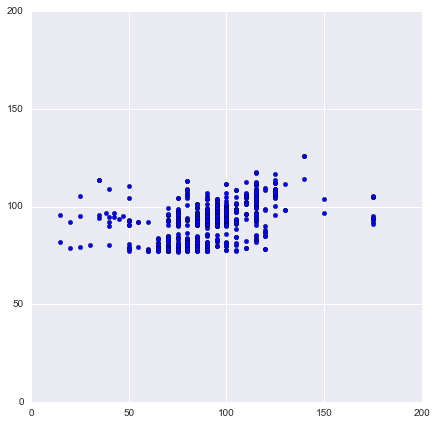

In [26]:
yhat1=sol1.predict(X1)
plt.figure(figsize=(7,7))
plt.scatter(y, yhat1)
plt.xlim([0,200])
plt.ylim([0,200])

Data with a notary fee <= 50 are not doing well here. Do some check below.

In [27]:
all[all.total_notary_fee <= 50].shape

(35, 15)

In [28]:
all[all.total_notary_fee <= 50].product_name.value_counts()

refinance           19
purchase            10
reverse mortgage     6
Name: product_name, dtype: int64

In [29]:
all[all.total_notary_fee <= 50].notary_id.value_counts().head(10)

38196    2
26246    2
62215    2
70855    2
72190    1
66415    1
70276    1
68840    1
51720    1
70665    1
Name: notary_id, dtype: int64

In [30]:
all[all.total_notary_fee <= 50]

,id,order_id,notary_id,messaged_at,responded_at,response,completed_status,state,company_id,total_notary_fee,city,appointment_date,product_name,travel_distance,docs_to_notary_sent
1,447670,549229,50684,2016-08-03 19:01:14,2016-08-03 19:01:49,available,did_not_sign,TN,3,50.00,Madison,8/3/16,purchase,8.489314,sent_by_client
27,440777,541394,62215,2016-07-28 16:53:48,2016-07-28 16:55:58,available,did_not_sign,AL,3,15.00,HUNTSVILLE,8/1/16,refinance,17.694577,direct_links
37,444844,545855,71141,2016-08-01 21:10:32,2016-08-01 21:11:05,not_available,completed,AL,0,40.00,Owens Cross Roads,8/1/16,refinance,14.452874,sent
69,447595,549115,43485,2016-08-03 18:26:12,2016-08-03 18:26:47,not_available,did_not_sign,TN,3,15.00,LOUDON,8/5/16,purchase,17.034900,sent
72,447803,549374,70276,2016-08-03 19:40:09,2016-08-03 19:40:48,available,did_not_sign,AL,3,45.00,NEW MARKET,8/4/16,refinance,11.837728,sent
144,437426,537551,50077,2016-07-26 18:14:22,2016-07-26 18:19:04,available,did_not_sign,TN,2,25.00,BLOUTVILLE,8/5/16,refinance,16.481087,sent_by_client
227,448922,550713,69645,2016-08-04 15:54:50,2016-08-04 16:07:26,available,canceled,AL,1,47.00,Madison,8/9/16,refinance,16.854548,sent_by_client
260,466251,570588,66680,2016-08-16 22:21:39,2016-08-16 22:22:27,available,completed,TN,0,40.00,Nashville,8/20/16,refinance,0.000000,sent
299,451847,554030,70855,2016-08-05 21:56:49,2016-08-05 21:57:27,available,on_hold,TN,2,50.00,CHATTANOOGA,8/7/16,purchase,5.319379,sent
361,458423,561654,38245,2016-08-11 14:27:32,2016-08-11 14:29:22,available,did_not_sign,AL,3,50.00,MONTGOMERY,8/12/16,refinance,10.475830,sent


In [31]:
#notary 38196 signed reverse mortgage with low fee < 50
orders[orders.notary_id==38196]

,order_id,completed_status,state,company_id,notary_id,total_notary_fee,city,appointment_date,product_name,travel_distance,docs_to_notary_sent
12,544853,completed,TN,0,38196.0,-1.0,KINGSTON,8/2/16,refinance,33.963280,overnighted
24,552829,on_hold,TN,2,38196.0,80.0,Knoxville,8/9/16,reverse mortgage,17.671643,emailed_to_notary
52,540437,canceled,TN,0,38196.0,85.0,Newport,8/5/16,purchase,37.189509,sent_by_client
64,569547,completed,TN,3,38196.0,-1.0,KNOXVILLE,8/17/16,refinance,12.807857,sent
65,569547,completed,TN,3,38196.0,-1.0,KNOXVILLE,8/17/16,refinance,12.807857,sent
90,581917,completed,TN,0,38196.0,35.0,White Pine,8/24/16,reverse mortgage,33.520433,sent
94,546509,completed,TN,1,38196.0,45.0,Sevierville,8/5/16,purchase,20.987759,sent
124,546499,completed,TN,1,38196.0,70.0,La Follette,8/3/16,purchase,23.027008,direct_links
260,569855,completed,TN,2,38196.0,70.0,Knoxville,8/18/16,purchase,2.954357,sent
261,569855,completed,TN,2,38196.0,70.0,Knoxville,8/18/16,purchase,2.954357,sent


In [32]:
#city seems to play a role
orders[orders.city=='White Pine']

,order_id,completed_status,state,company_id,notary_id,total_notary_fee,city,appointment_date,product_name,travel_distance,docs_to_notary_sent
90,581917,completed,TN,0,38196.0,35.0,White Pine,8/24/16,reverse mortgage,33.520433,sent
1128,588760,canceled,TN,0,NaN,70.0,White Pine,8/26/16,reverse mortgage,NaN,NaN


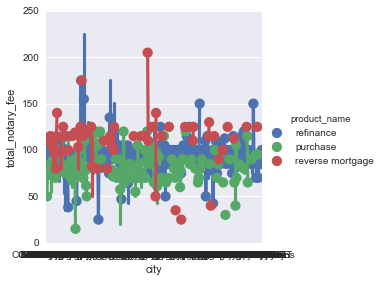

In [33]:
#plt.figure(figsize=(10,18))
sns.factorplot(x='city', y='total_notary_fee',  hue='product_name', data=all, figsize=(8,16))

Many cities have only 1 data point. More data are needed to see if city is a contributing factor to price.

## 4. Conclusion
The pricing guide was developed with a linear regression model. The results suggest that notary fees are based on two major factors - product category and notary travel distance. The recommendation includes

1). Reverse mortgage should be priced as the highest, followed by refinance and purchase. Exceptions may occur at some cities;

2). Notaries who travels further (for signing) should be priced higher.